In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
import pandas as pd
from dw_config.location import Turbine
from dw_database.utils import DynawindFrame

nw2c02_df = pd.read_parquet(r"C:\Users\Max\Documents\OWI_LAB\Code\DCE_EOVnorm\dce_eov_normalisation\data\raw\nw2\nw2c02.parquet")
nw2c02_df.drop('location', axis=1, inplace=True)
def rename_mpe_cols(data: pd.DataFrame, replcement:str = 'mode_'):
    for col in nw2c02_df.columns:
        if 'mpe_' in col:
            nw2c02_df.rename(columns={col: col.replace('mpe_', replcement)}, inplace=True)
    return data
            
nw2c02_df = rename_mpe_cols(nw2c02_df, replcement='mode_')

In [4]:
#location = Location('NW2C02')
location = Turbine('NW2C02')
dwf_ = DynawindFrame(df=nw2c02_df, location=location)

In [5]:
loc = 'nw2'
turbine = 'c02'
mode = 'SS2'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
selected_data_little = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_little.csv'))
selected_data_large = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
selected_data_large.set_index('timestamp', inplace=True)
selected_data_large.index = pd.to_datetime(selected_data_large.index)
selected_data_little.set_index('timestamp', inplace=True)
selected_data_little.index = pd.to_datetime(selected_data_little.index)

In [7]:
#load the predictions of the training data
predictions_df_training = pd.read_parquet(os.path.join(data_folder, 'processed', loc, turbine+'_'+mode+'_mode_prediction_large_training.parquet'))
smart_tracked_modes_training = pd.read_parquet(os.path.join(data_folder, 'processed', loc, turbine+'_'+mode+'_smart_tracked_modes_large_training.parquet'))

In [8]:
dwf_smart_tracked = DynawindFrame(nw2c02_df.loc[smart_tracked_modes_training.index], location=location)

In [9]:
dwf_training = DynawindFrame(nw2c02_df.loc[selected_data_large.index], location=location)

In [10]:
dwf_.case_stats()

,Abs,Rel.,Time
parked,1600,3,11 days 02:40:00
pitch:78,1506,2,10 days 11:00:00
idling,1149,2,7 days 23:30:00
cutin,4423,7,30 days 17:10:00
cutin (pitch > 20),2848,5,19 days 18:40:00
rpm<6.6,3418,6,23 days 17:40:00
rpm6.6,8428,14,58 days 12:40:00
Rated power,5838,10,40 days 13:00:00
rpm<Max,20997,34,145 days 19:30:00
Rated RPM,3648,6,25 days 08:00:00


In [11]:
dwf_training.case_stats()

,Abs,Rel.,Time
parked,1001,19,6 days 22:50:00
pitch:78,550,10,3 days 19:40:00
idling,120,2,0 days 20:00:00
cutin,811,15,5 days 15:10:00
cutin (pitch > 20),225,4,1 days 13:30:00
rpm<6.6,289,5,2 days 00:10:00
rpm6.6,803,15,5 days 13:50:00
Rated power,5,0,0 days 00:50:00
rpm<Max,956,18,6 days 15:20:00
Rated RPM,6,0,0 days 01:00:00


In [12]:
def plot_case_donuts(results, results_month):
    case_stats_df = results.case_stats()
    case_stats_df_month = results_month.case_stats()
    colors = [c.color for c in results.case_definitions]
    colors.append('lightgrey')
    label = results.case_definitions
    labels = [str(item).split(': ')[0] for item in label]
    labels.append('Other')
    a, b = plt.pie(case_stats_df_month['Abs'][:], colors=colors, radius=1.8, wedgeprops=dict(width=0.3, edgecolor='lightgrey'))
    a, b = plt.pie(case_stats_df['Abs'][:], colors=colors, radius=1.5, wedgeprops=dict(width=0.1, edgecolor='lightgrey'))
    labels_parent = ['Events','Standstill','Operational','Derated','Missing SCADA','Other']
    colors_parent = ['magenta','LimeGreen', 'darkgoldenrod', 'SteelBlue', 'silver', 'lightgrey']
    c, d = plt.pie(
        [case_stats_df_month['Abs'][0], sum(case_stats_df_month['Abs'][1:3]), sum(case_stats_df_month['Abs'][3:10]),
         sum(case_stats_df_month['Abs'][10:15]), case_stats_df_month['Abs'][-2], case_stats_df_month['Abs'][-1]],
        radius=1.3, colors=colors_parent, wedgeprops=dict(width=0.3, edgecolor='w'))
    c, d = plt.pie([case_stats_df['Abs'][0], sum(case_stats_df['Abs'][1:3]), sum(case_stats_df['Abs'][3:10]),
                    sum(case_stats_df['Abs'][10:15]),case_stats_df['Abs'][-2],case_stats_df['Abs'][-1]],
                   radius=1, colors=colors_parent, wedgeprops=dict(width=0.1, edgecolor='w'))
    plt.gca().set(aspect="equal")
    legend_cases = plt.legend(a, labels, bbox_to_anchor=(1.25, 1.2), loc='upper left', fontsize=22, borderaxespad=0.)
    plt.legend(c, labels_parent, bbox_to_anchor=(2.5, 0.85), loc='upper left', fontsize=22, borderaxespad=0.)
    plt.gca().add_artist(legend_cases)
    

In [13]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def plot_case_donuts(results, results_month, label1='All data', label2='Training data'):
    case_stats_df = results.case_stats()
    case_stats_df_month = results_month.case_stats()
    colors = [c.color for c in results.case_definitions]
    colors.append('lightgrey')
    label = results.case_definitions
    labels = [str(item).split(': ')[0] for item in label]
    labels.append('Other')
    a, b = plt.pie(case_stats_df_month['Abs'][:], colors=colors, radius=1.8, wedgeprops=dict(width=0.3, edgecolor='lightgrey'))
    a, b = plt.pie(case_stats_df['Abs'][:], colors=colors, radius=1.4, wedgeprops=dict(width=0.3, edgecolor='lightgrey'))
    # labels_parent = ['Events','Standstill','Operational','Derated','Missing SCADA','Other']
    # colors_parent = ['magenta','LimeGreen', 'darkgoldenrod', 'SteelBlue', 'silver', 'lightgrey']
    # c, d = plt.pie(
    #     [case_stats_df_month['Abs'][0], sum(case_stats_df_month['Abs'][1:3]), sum(case_stats_df_month['Abs'][3:10]),
    #      sum(case_stats_df_month['Abs'][10:15]), case_stats_df_month['Abs'][-2], case_stats_df_month['Abs'][-1]],
    #     radius=1.3, colors=colors_parent, wedgeprops=dict(width=0.3, edgecolor='w'))
    # c, d = plt.pie([case_stats_df['Abs'][0], sum(case_stats_df['Abs'][1:3]), sum(case_stats_df['Abs'][3:10]),
    #                 sum(case_stats_df['Abs'][10:15]),case_stats_df['Abs'][-2],case_stats_df['Abs'][-1]],
    #                radius=1, colors=colors_parent, wedgeprops=dict(width=0.1, edgecolor='w'))
    plt.gca().set(aspect="equal")
    legend_cases = plt.legend(a, labels, bbox_to_anchor=(1.25, 1.2), loc='upper left', fontsize=22, borderaxespad=0.)
    #legend_op = plt.legend(c, labels_parent, bbox_to_anchor=(2.5, 0.85), loc='upper left', fontsize=22, borderaxespad=0.)
    #plt.gca().add_artist(legend_cases)
    #plt.legend
    #plt.gca().add_artist(legend_op)


    # Create dummy patches for the legend
    # large_donut_handle = mlines.Line2D([], [], color='grey', marker='s', markersize=20, label='Large Donut (label 1)', linestyle='None')
    # thin_donut_handle = mlines.Line2D([], [], color='lightgrey', marker='s', markersize=10, label='Thin Donut (label 2)', linestyle='None')
    # # large_donut_patch = mpatches.Patch(color='grey', label='Large Donut (label 1)')
    # # thin_donut_patch = mpatches.Patch(color='lightgrey', label='Thin Donut (label 2)')

    # # Add the new legend to the plot
    # plt.legend(handles=[large_donut_handle, thin_donut_handle], bbox_to_anchor=(3.5,1.3), fontsize=22, borderaxespad=0.)

    # Your existing legend code...
    # Ensure you keep the plt.gca().add_artist(legend_cases) line to maintain the original legend
    #plt.text(-0.35, 1.85, label1, fontsize=22)
    plt.text(-0.65, 1.85, label1, fontsize=22)
    plt.text(-0.65, 0.6, label2, fontsize=22)
    plt.show()
    

In [14]:
def power_curve_plot(results):
    plt.figure(figsize=(20, 10))
    colors = [c.color for c in results.case_definitions]
    colors.append('lightgrey')
    label = results.case_definitions
    labels = [str(item).split(': ')[0] for item in label]
    labels.append('Other')
    a = dwf_.plot(x='mean_windspeed',y='mean_power', color_by_case=True, marker='.', linestyle='')
    plt.legend(labels = labels, bbox_to_anchor=(1.25, 1.2), loc='upper left', fontsize=22, borderaxespad=0.)
    plt.gcf().set_figwidth(15)

In [ ]:
dwf_.plot(x='mean_windspeed',y='mean_power', color_by_case=True, marker='.', linestyle='')
plt.gcf().set_figwidth(15)

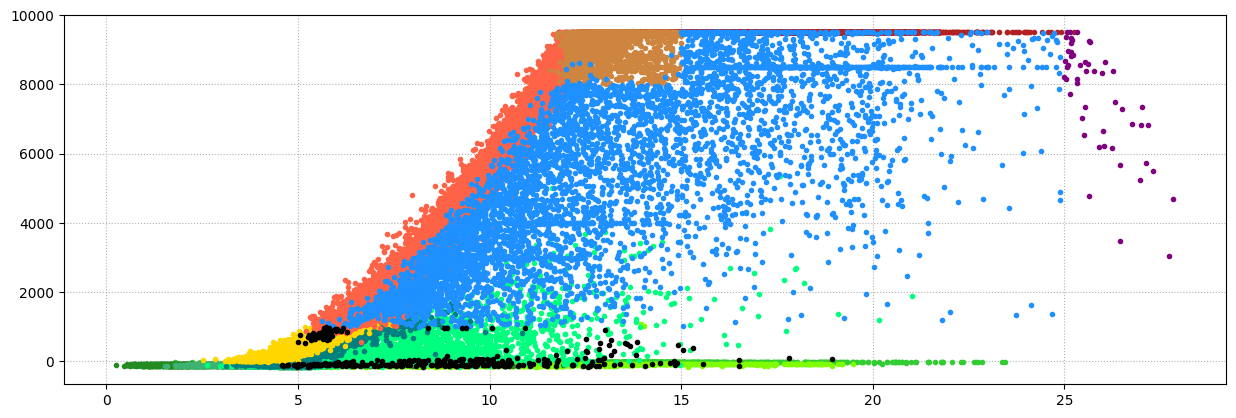

In [15]:
dwf_.plot(x='mean_windspeed',y='mean_power', color_by_case=True, marker='.', linestyle='')
plt.gcf().set_figwidth(15)

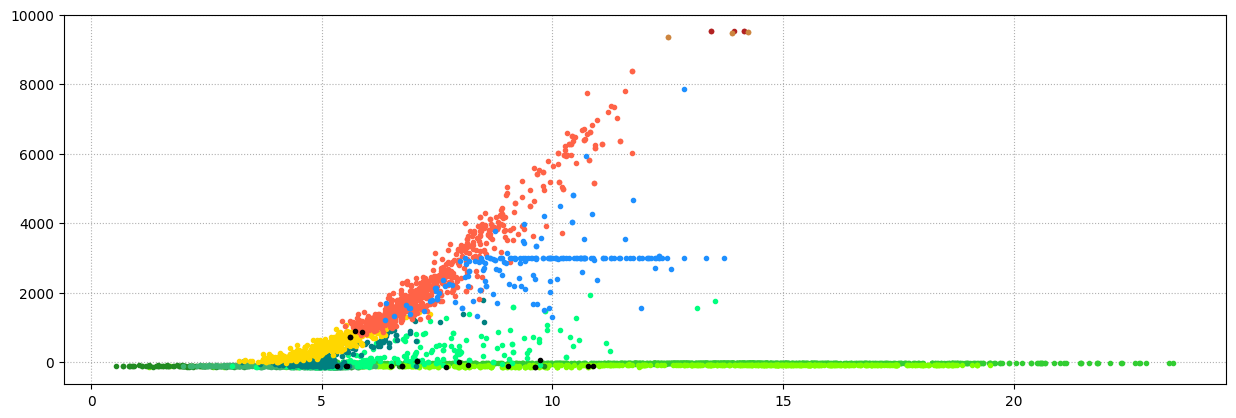

In [16]:
dwf_training.plot(x='mean_windspeed',y='mean_power', color_by_case=True, marker='.', linestyle='')
plt.gcf().set_figwidth(15)

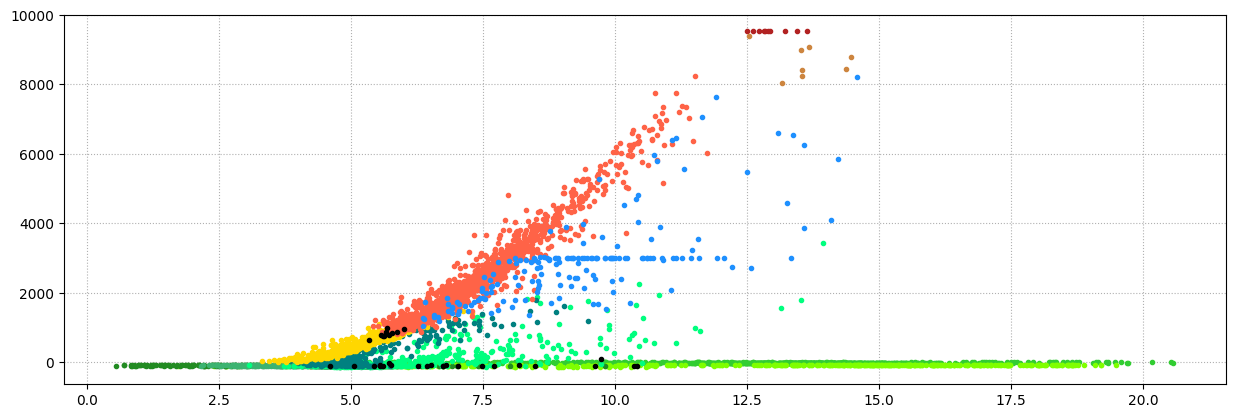

In [17]:
dwf_smart_tracked.plot(x='mean_windspeed',y='mean_power', color_by_case=True, marker='.', linestyle='')
plt.gcf().set_figwidth(15)

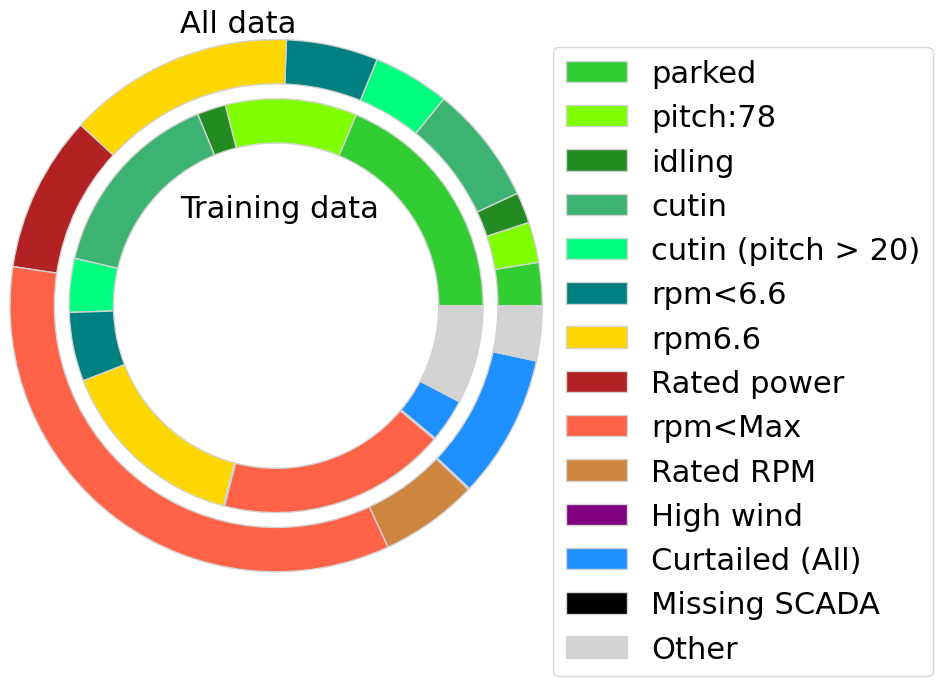

In [18]:
plot_case_donuts(dwf_training, dwf_)

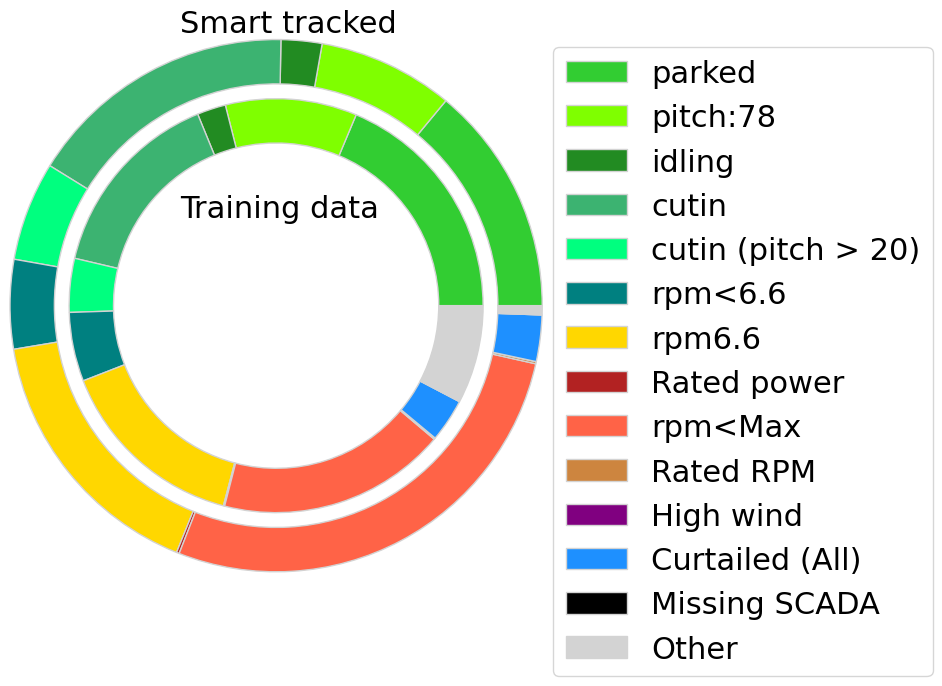

In [19]:
plot_case_donuts(dwf_training, dwf_smart_tracked, label1='Smart tracked')

In [20]:
# Calculate the cumulative sum of the 'Abs' column
cases = dwf_.case_stats()
cases['Cumulative'] = cases['Rel.'].cumsum()
cases_training = dwf_training.case_stats()
cases_training['Cumulative'] = cases_training['Rel.'].cumsum()
cases_smart_tracked = dwf_smart_tracked.case_stats()
cases_smart_tracked['Cumulative'] = cases_smart_tracked['Rel.'].cumsum()
df1 = cases.reset_index().rename(columns={'index':'State'})
df2 = cases_training.reset_index().rename(columns={'index':'State'})
df3 = cases_smart_tracked.reset_index().rename(columns={'index':'State'})

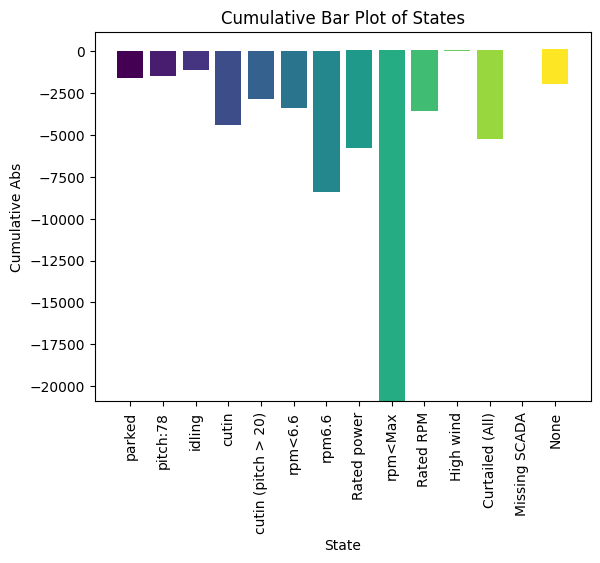

In [21]:
# Plot
fig, ax = plt.subplots()
states = cases.index
colors = plt.cm.viridis(np.linspace(0, 1, len(states)))  # Example color map

for i, state in enumerate(states):
    ax.bar(state, cases.loc[state, 'Abs'], bottom=cases.loc[state, 'Cumulative'] - cases.loc[state, 'Abs'], color=colors[i])

ax.set_title('Cumulative Bar Plot of States')
ax.set_xlabel('State')
ax.set_ylabel('Cumulative Abs')

plt.xticks(rotation=90)
plt.show()

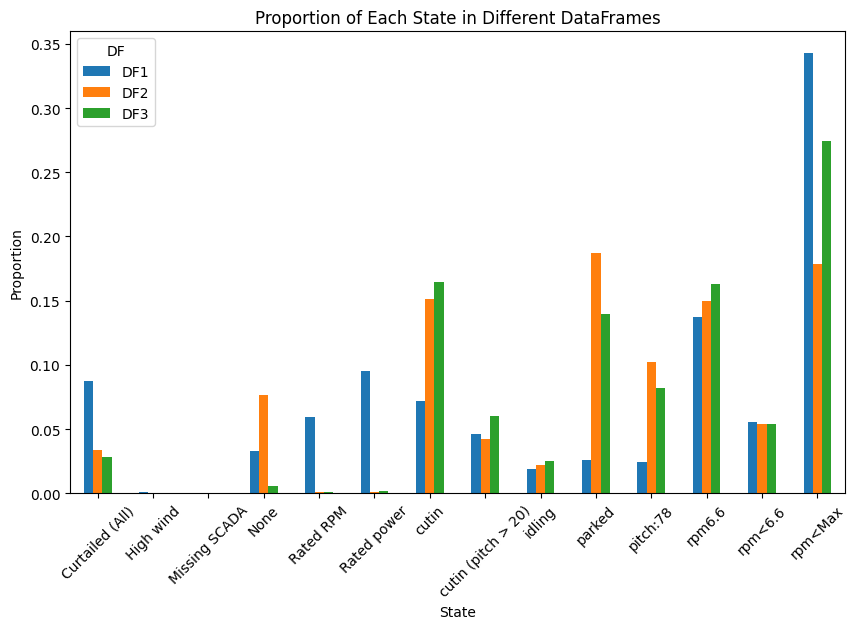

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df1, df2, and df3 are your DataFrames
# Calculate proportions
df1['Proportion'] = df1['Abs'] / df1['Abs'].sum()
df2['Proportion'] = df2['Abs'] / df2['Abs'].sum()
df3['Proportion'] = df3['Abs'] / df3['Abs'].sum()

# Combine the data
combined_df = pd.concat([
    df1[['State', 'Proportion']].assign(DF='DF1'),
    df2[['State', 'Proportion']].assign(DF='DF2'),
    df3[['State', 'Proportion']].assign(DF='DF3')
])

# Pivot for plotting
pivot_df = combined_df.pivot(index='State', columns='DF', values='Proportion')

# Plot
pivot_df.plot(kind='bar', figsize=(10, 6))

plt.title('Proportion of Each State in Different DataFrames')
plt.xlabel('State')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()

<BarContainer object of 14 artists>

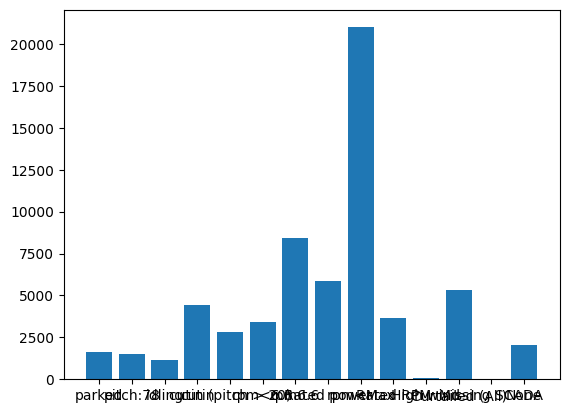

In [23]:
plt.bar(dwf_.case_stats().index, dwf_.case_stats()['Abs'])

In [24]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def plot_case_donuts(data1, data2, data3, label1='All data', label2='Training data', label3='Smart tracked'):
    case_stats1 = data1.case_stats()
    case_stats2 = data2.case_stats()
    case_stats3 = data3.case_stats()
    colors = [c.color for c in data1.case_definitions]
    colors.append('lightgrey')
    label = data1.case_definitions
    labels = [str(item).split(': ')[0] for item in label]
    labels.append('Other')
    a, b = plt.pie(case_stats1['Abs'][:], colors=colors, radius=2.0, wedgeprops=dict(width=0.3, edgecolor='lightgrey'))
    a, b = plt.pie(case_stats2['Abs'][:], colors=colors, radius=1.6, wedgeprops=dict(width=0.3, edgecolor='lightgrey'))
    a, b = plt.pie(case_stats3['Abs'][:], colors=colors, radius=1.2, wedgeprops=dict(width=0.3, edgecolor='lightgrey'))
    plt.gca().set(aspect="equal")
    legend_cases = plt.legend(a, labels, bbox_to_anchor=(1.4, 1.35), loc='upper left', fontsize=22, borderaxespad=0.)
    #legend_op = plt.legend(a, labels, bbox_to_anchor=(2.5, 0.85), loc='upper left', fontsize=22, borderaxespad=0.)
    #plt.gca().add_artist(legend_cases)
    #plt.legend()
    #plt.gca().add_artist(legend_op)


    # Create dummy patches for the legend
    # large_donut_handle = mlines.Line2D([], [], color='grey', marker='s', markersize=20, label='Large Donut (label 1)', linestyle='None')
    # thin_donut_handle = mlines.Line2D([], [], color='lightgrey', marker='s', markersize=10, label='Thin Donut (label 2)', linestyle='None')
    # # large_donut_patch = mpatches.Patch(color='grey', label='Large Donut (label 1)')
    # # thin_donut_patch = mpatches.Patch(color='lightgrey', label='Thin Donut (label 2)')

    # # Add the new legend to the plot
    # plt.legend(handles=[large_donut_handle, thin_donut_handle], bbox_to_anchor=(3.5,1.3), fontsize=22, borderaxespad=0.)

    # Your existing legend code...
    # Ensure you keep the plt.gca().add_artist(legend_cases) line to maintain the original legend
    plt.text(-0.35, 1.6, label1, fontsize=22)
    plt.text(-0.65, 1.2, label2, fontsize=22)
    plt.text(-0.65, 0.7, label3, fontsize=22)
    plt.show()
    

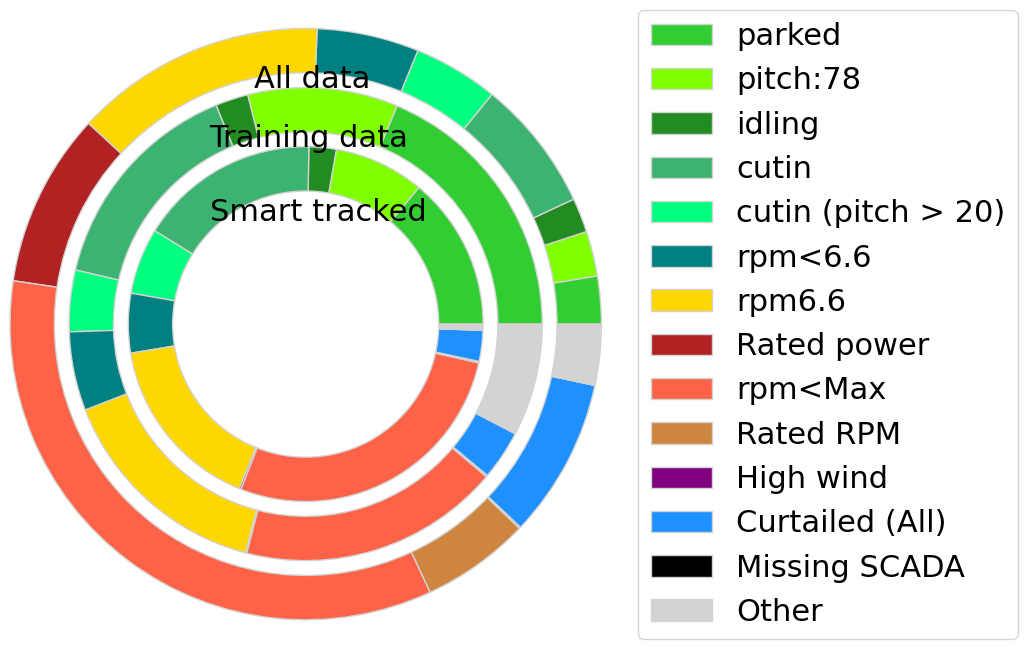

In [25]:
plot_case_donuts(dwf_, dwf_training, dwf_smart_tracked)

In [26]:
dwf_.case_stats()

,Abs,Rel.,Time
parked,1600,3,11 days 02:40:00
pitch:78,1506,2,10 days 11:00:00
idling,1149,2,7 days 23:30:00
cutin,4423,7,30 days 17:10:00
cutin (pitch > 20),2848,5,19 days 18:40:00
rpm<6.6,3418,6,23 days 17:40:00
rpm6.6,8428,14,58 days 12:40:00
Rated power,5838,10,40 days 13:00:00
rpm<Max,20997,34,145 days 19:30:00
Rated RPM,3648,6,25 days 08:00:00


In [27]:
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import text as mtext
import numpy as np
import math
class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes,start_pos=0, fontsize=12, **kwargs):
        super(CurvedText, self).__init__(x[0], y[0], ' ', **kwargs)
        axes.add_artist(self)
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()
        self.__Characters = []
        self.start_pos = start_pos  # Starting position of the text
        self.fontsize = fontsize  # Font size of the text
        for c in text:
            if c == ' ':
                t = mtext.Text(0, 0, 'a', fontsize=self.fontsize)
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0, 0, c, fontsize=self.fontsize, **kwargs)
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder + 1)
            self.__Characters.append((c, t))
            axes.add_artist(t)
    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)
    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)
    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """
        #preparations
        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357
        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])
        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )
        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)
        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)
        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)
        rel_pos = self.start_pos
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height
            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue
            elif c != ' ':
                t.set_alpha(1.0)
            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]
            #if we exactly hit a data point:
            if ir == il:
                ir += 1
            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]
            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]
            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])
            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)
            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])
            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])
            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)
            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])
            t.set_va('center')
            t.set_ha('center')
            #updating rel_pos to right edge of character
            rel_pos += w-used

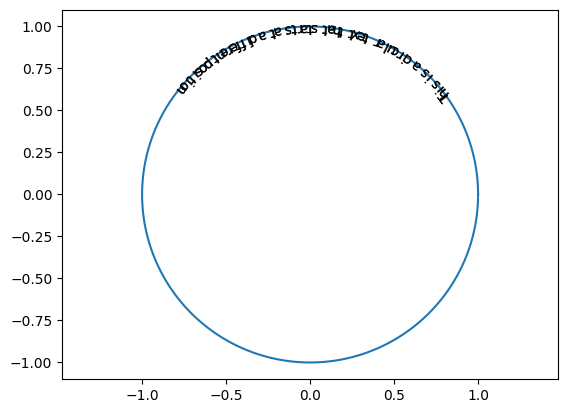

In [28]:
import matplotlib.pyplot as plt
from matplotlib.text import Text as mtext
import numpy as np
import math

class CurvedText(mtext):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, start_pos=0, fontsize=12, **kwargs):
        # Extend the superclass with an empty string
        super().__init__(x=x[0], y=y[0], text='', fontsize=fontsize, **kwargs)
        self.x = x
        self.y = y
        self.axes = axes
        self.axes.add_artist(self)
        self.text = text
        self.start_pos = start_pos  # Fractional start position along the curve
        self.fontsize = fontsize

        # Create text objects for each character
        self.text_objects = [self._make_text(t, **kwargs) for t in text]

    def _make_text(self, char, **kwargs):
        text = mtext(x=0, y=0, text=char, **kwargs)
        text.set_fontsize(self.fontsize)
        self.axes.add_artist(text)
        return text

    def draw(self, renderer):
        # Override the draw method to reposition the text objects
        scale = renderer.points_to_pixels(self.fontsize)

        # Calculate the arc length of the curve
        distances = np.hypot(np.diff(self.x), np.diff(self.y))
        arc = np.insert(np.cumsum(distances), 0, 0)

        # Find the starting index based on start_pos
        start_index = np.searchsorted(arc, arc[-1] * self.start_pos)

        # Calculate the fraction of the total arc length at which to place each character
        for i, (char_arc, text_object) in enumerate(zip(arc[start_index:], self.text_objects)):
            if i + start_index >= len(self.x) - 1:
                # Skip characters that don't fit on the curve
                continue

            # Interpolate to find the exact position
            t = (char_arc - arc[i + start_index]) / (arc[i + start_index + 1] - arc[i + start_index])

            # Position the character
            x = self.x[i + start_index] + (self.x[i + start_index + 1] - self.x[i + start_index]) * t
            y = self.y[i + start_index] + (self.y[i + start_index + 1] - self.y[i + start_index]) * t
            angle = math.degrees(math.atan2(self.y[i + start_index + 1] - self.y[i + start_index],
                                            self.x[i + start_index + 1] - self.x[i + start_index]))

            # Set the position and rotation
            text_object.set_x(x)
            text_object.set_y(y)
            text_object.set_rotation(angle)
            text_object.set_va('center')
            text_object.set_ha('center')

            # Draw the character
            text_object.draw(renderer)

        # Call superclass draw method
        super().draw(renderer)

# Example usage
fig, ax = plt.subplots()
N = 200
curve = [
    np.cos(np.linspace(0, 2*np.pi, N)),
    np.sin(np.linspace(0, 2*np.pi, N)),
]

# Plot the curve
ax.plot(*curve)

# Create the CurvedText object
curved_text = CurvedText(
    x=curve[0],
    y=curve[1],
    text="This is a circular text that starts at a different position",
    axes=ax,  # Adds the text to the axes
    start_pos=0.1,  # Starting position (0% along the curve)
    fontsize=10  # Font size
)

plt.axis('equal')
plt.show()


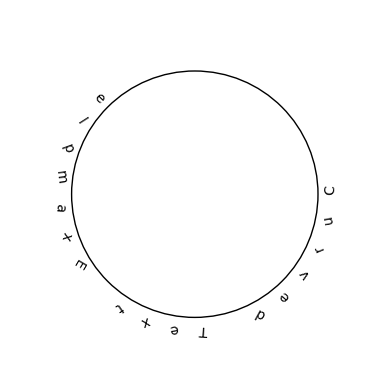

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def place_text_around_circle(ax, text, center, radius, start_angle=90, fontsize=10):
    # Calculate total arc length needed for text
    arc_per_char = 2 * np.pi / (len(text) * 1.5)  # Adjust the denominator for spacing
    total_arc_length = arc_per_char * len(text)

    # Calculate starting angle based on start_angle and total_arc_length
    current_angle = start_angle + total_arc_length / 2

    for char in text:
        # Adjust angles for each character
        theta = np.deg2rad(current_angle)  # Convert angle to radians
        x = center[0] + radius * np.cos(theta)
        y = center[1] + radius * np.sin(theta)
        rotation = np.rad2deg(np.pi/2 - theta)  # Correct the rotation of text

        # Add text to the plot
        ax.text(x, y, char, ha='center', va='center', rotation=rotation,
                fontsize=fontsize, family='sans-serif')

        # Update the current_angle
        current_angle -= np.degrees(arc_per_char)

# Example usage:
fig, ax = plt.subplots()
circle = plt.Circle((0, 0), 1, fill=False, color='black')
ax.add_artist(circle)

place_text_around_circle(ax, "Curved Text Example", center=(0, 0), radius=1.1, start_angle=0, fontsize=10)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
plt.axis('off')  # Hide the axis
plt.show()


AttributeError: 'PathPatch' object has no attribute 'set_rotation'

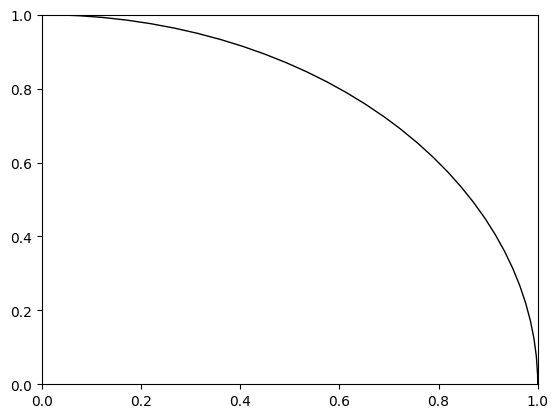

In [30]:
import matplotlib.pyplot as plt
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties

def place_text_around_circle(ax, text, center, radius, start_angle=90, fontsize=10):
    fontprops = FontProperties(family="sans-serif", style='normal', size=fontsize)
    arc_length = 0  # Initialize the arc length
    for char in text:
        # Measure the width of the character
        tp = TextPath((0, 0), char, prop=fontprops)
        bb = tp.get_extents()
        char_width = bb.width * fontsize / 10  # Adjust by fontsize
        
        # Convert character width from pixels to radians
        char_width_rad = char_width / radius
        
        # Calculate the angle for this character
        angle = start_angle + arc_length / radius
        
        # Place the character at the correct angle
        x = center[0] + radius * np.cos(angle)
        y = center[1] + radius * np.sin(angle)
        rotation = np.degrees(angle)
        
        # Create a text object for the character
        text_patch = PathPatch(tp, lw=0, fc='black', transform=ax.transData)
        trans = plt.gca().transData.transform
        trans_angle = plt.gca().transData.transform_angles(np.array((rotation,)), 
                                                           np.array((x, y)).reshape((1, 2)))[0]
        
        # Apply translation and rotation to the character
        t = trans((x, y))
        text_patch.set_transform(plt.gca().transData)
        text_patch.set_rotation(trans_angle)
        text_patch.set_translation(t)
        
        ax.add_patch(text_patch)
        
        # Increment the arc length by the width of the character
        arc_length += char_width_rad

# Example usage:
fig, ax = plt.subplots()
circle = plt.Circle((0, 0), 1, fill=False)
ax.add_artist(circle)

place_text_around_circle(ax, "Curved Text Example", center=(0, 0), radius=1.1, start_angle=np.pi/4, fontsize=10)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
plt.show()


-0.7266411690715989 0.8258284394535346 C 41.34434176873396
-0.6409565224960477 0.8939657355121468 u 35.639807395290084
-0.5631010684351997 0.9449429542184739 r 30.791141983245453
-0.4583479745095844 0.9999585662731039 v 24.625157261714577
-0.3511563922527133 1.0424438537302902 e 18.616551395741794
-0.24221730958916188 1.0730008270897968 d 12.720636562143923
-0.18843153785025066 1.0837405388483858   9.863493705001076
-0.07838098463445548 1.0972039105142368 E 4.0860987502803
0.039698509804060304 1.0992834158302112 x -2.0682282782462664
0.14924948678726374 1.0898277802908765 a -7.798020986532805
0.296170483894353 1.0593786124279576 m -15.619398114674723
0.4034942706541736 1.023324178131865 p -21.51919884594068
0.4637477447061745 0.9974658035641808 l -24.93493949287307
0.5656125656410367 0.9434417976690265 e -30.94354535884584
0.611936156636511 0.9140755659139652   -33.80068821598873
0.6653102337215222 0.8759921762809378 l -37.21642886292108
0.7163204598783282 0.8347963816163202 l -40.6321

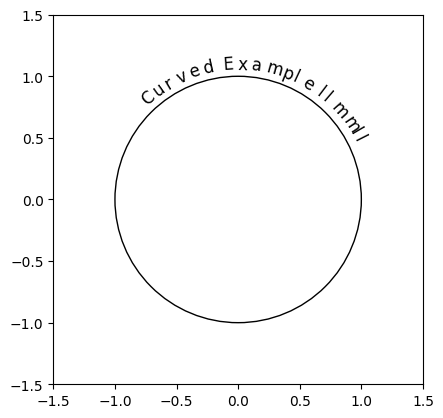

In [ ]:
# Simplified example to space characters evenly along a circular path

def place_text_around_circle(ax, text, center, radius, start_angle=0, fontsize=16, arc_len = np.pi):
    fontprops = FontProperties(family="sans-serif", style='normal', size=fontsize)
    arc_per_char = arc_len / len(text)  # Evenly space characters around the circle
    angles = start_angle + arc_per_char * np.arange(len(text))
    arc_length = 0  # Initialize the arc length
    
    for char, angle in zip(text, angles):
        # Measure the width of the character
        tp = TextPath((0, 0), char, prop=fontprops)
        bb = tp.get_extents()
        char_width = bb.width/fontsize  # Adjust by fontsize
        # Convert character width from pixels to radians
        char_width_rad = char_width / (2*arc_len*radius)

        
        # Calculate the angle for this character
        if char_width_rad > 0:
            angle_ = angle + arc_length + char_width_rad/4
        else:
            angle_ = angle + arc_length
        x = center[0] - radius * np.cos(angle_)
        y = center[1] + radius * np.sin(angle_)
        rotation = np.degrees(-angle_) + 90  # Rotate text to align with the circle
        ax.text(x, y, char, ha='center', va='center', rotation=rotation, fontsize=fontsize)
        print(x, y, char, rotation)

        # Increment the arc length by the width of the character
        if char_width_rad > 0:
            arc_length += char_width_rad/4
    

# Example usage:
fig, ax = plt.subplots()
circle = plt.Circle((0, 0), 1, fill=False)
ax.add_artist(circle)

place_text_around_circle(ax, "Curved Example llmmll", center=(0, 0), radius=1.1, start_angle=np.pi/4, fontsize=12, arc_len=np.pi/3)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
plt.show()
plt.close()

init All data
here All data [0.         0.04908739 0.09817477 0.14726216 0.19634954 0.24543693
 0.29452431 0.3436117 ]
init Training data
here Training data [0.         0.06041524 0.12083049 0.18124573 0.24166097 0.30207622
 0.36249146 0.4229067  0.48332195 0.54373719 0.60415243 0.66456768
 0.72498292]
init Smart tracked
here Smart tracked [0.         0.08055366 0.16110732 0.24166097 0.32221463 0.40276829
 0.48332195 0.5638756  0.64442926 0.72498292 0.80553658 0.88609024
 0.96664389]


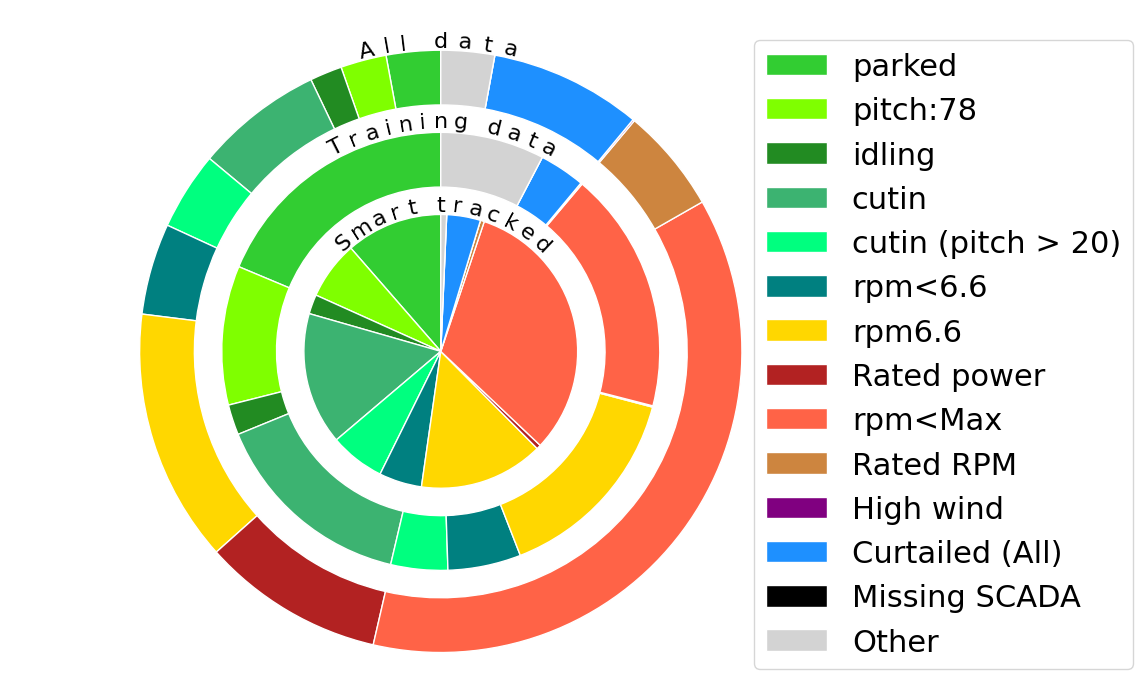

In [ ]:
from matplotlib.font_manager import FontProperties
def place_text_around_circle(ax, text, center, radius, mid_angle=0, fontsize=16, arc_len = np.pi):
    print('init', text)
    fontprops = FontProperties(family="sans-serif", style='normal', size=fontsize)
    arc_per_char = arc_len / len(text)  # Evenly space characters around the circle
    angles =  arc_per_char * np.arange(len(text))
    arc_length = 0  # Initialize the arc length
    angles_ = []
    print('here', text, angles)
    for char, angle in zip(text, angles):
        # Measure the width of the character
        tp = TextPath((0, 0), char, prop=fontprops)
        bb = tp.get_extents()
        char_width = bb.width/fontsize  # Adjust by fontsize
        # Convert character width from pixels to radians
        char_width_rad = char_width / (2*arc_len*radius**2)

        
        # Calculate the angle for this character
        if char_width_rad > 0:
            angle_ = angle + arc_length + char_width_rad/6
        else:
            angle_ = angle + arc_length
        angles_.append(angle_)
        # Increment the arc length by the width of the character
        if char_width_rad > 0:
            arc_length += char_width_rad/4

    for char, angle_ in zip(text, angles_):
        #center angles around mid_angle
        angle_ = angle_ - angles_[int(len(angles_)/2)] + mid_angle
        x = center[0] - radius * np.cos(angle_)
        y = center[1] + radius * np.sin(angle_)
        rotation = np.degrees(-angle_) + 90  # Rotate text to align with the circle
        ax.text(x, y, char, ha='center', va='center', rotation=rotation, fontsize=fontsize)

        



def plot_case_donuts(data1, data2, data3, 
                     labels=['All data','Training data','Smart tracked'], 
                     radiuses = [2.0, 1.5, 1.0],
                     mid_angles = [np.pi/4, np.pi/4, np.pi/4],
                     arc_lens = [np.pi/2, np.pi/2, np.pi/2],
                     show_percent=False, 
                     figsize=(12, 8),
                     fontsize=16):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('equal')

    # Assuming case_stats is a method that returns a dictionary with 'Abs' and 'Perc' keys with lists as values
    case_stats1 = data1.case_stats()
    case_stats2 = data2.case_stats()
    case_stats3 = data3.case_stats()
    colors = [c.color for c in data1.case_definitions]
    colors.append('lightgrey')
    labels_ = [str(item).split(': ')[0] for item in data1.case_definitions]
    labels_.append('Other')

    # Create a pie chart for each set of data
    wedges1, texts1 = plt.pie(case_stats1['Abs'][:], colors=colors, radius=radiuses[0], wedgeprops=dict(width=0.4, edgecolor='w'), startangle=90)
    wedges2, texts2 = plt.pie(case_stats2['Abs'][:], colors=colors, radius=radiuses[1], wedgeprops=dict(width=0.4, edgecolor='w'), startangle=90)
    wedges3, texts3 = plt.pie(case_stats3['Abs'][:], colors=colors, radius=radiuses[2], wedgeprops=dict(width=1.0, edgecolor='w'), startangle=90)


    place_text_around_circle(ax, labels[0], center=(0,0), radius = radiuses[0]*1.03, mid_angle=mid_angles[0], fontsize=fontsize, arc_len = arc_lens[0])
    place_text_around_circle(ax, labels[1], center=(0,0), radius = radiuses[1]*1.05, mid_angle=mid_angles[1], fontsize=fontsize, arc_len = arc_lens[1])
    place_text_around_circle(ax, labels[2], center=(0,0), radius = radiuses[2]*1.07, mid_angle=mid_angles[2], fontsize=fontsize, arc_len = arc_lens[2])

    # Add the percentages to the wedges
    if show_percent:
        for wedge, stats in zip([wedges1, wedges2, wedges3], [case_stats1['Abs'], case_stats2['Abs'], case_stats3['Abs']]):
            for w, percent in zip(wedge, stats):
                if percent >= 2.0:
                    angle = (w.theta2 + w.theta1) / 2
                    if w.width < w.r:
                        x = (w.r - w.width/2) * 1.0 * np.cos(np.radians(angle))
                        y = (w.r - w.width/2) * 1.0 * np.sin(np.radians(angle))
                        plt.text(x, y, f'{np.round(percent)}', ha='center', va='center', fontsize=8)
                    else:
                        x = (w.r - w.width/8) * 1.0 * np.cos(np.radians(angle))
                        y = (w.r - w.width/8) * 1.0 * np.sin(np.radians(angle))
                        plt.text(x, y, f'{np.round(percent)}', ha='center', va='center', fontsize=8)
    plt.gca().set(aspect="equal")
    legend_cases = plt.legend(wedges2, labels_, bbox_to_anchor=(0.8, 0.95), loc='upper left', fontsize=22, borderaxespad=0.)

    # plt.text(-0.25, 0.2, 'Data', fontsize=20)
    # plt.text(-0.55, -0.05, 'description', fontsize=20)

    plt.gca().set(aspect="equal")
    plt.xlim(-2, 2.5)
    plt.ylim(-2, 2.5)
    plt.show()
    plt.close()

plot_case_donuts(dwf_, dwf_training, dwf_smart_tracked, radiuses = [2.2, 1.6, 1.0],  show_percent=False, mid_angles=[np.pi/2, np.pi/2, np.pi/2], arc_lens=[np.pi/8, np.pi/4, np.pi/3])

In [ ]:
from matplotlib.font_manager import FontProperties




def plot_case_donuts(data1, data2, data3, 
                     labels=['All data','Training data','Smart tracked'], 
                     radiuses = [2.0, 1.5, 1.0], 
                     show_percent=False, 
                     figsize=(12, 8),
                     N = [80, 80, 80],
                     start_pos = [0.0, 0.0, 0.0]):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('equal')

    # Assuming case_stats is a method that returns a dictionary with 'Abs' and 'Perc' keys with lists as values
    case_stats1 = data1.case_stats()
    case_stats2 = data2.case_stats()
    case_stats3 = data3.case_stats()
    colors = [c.color for c in data1.case_definitions]
    colors.append('lightgrey')
    labels_ = [str(item).split(': ')[0] for item in data1.case_definitions]
    labels_.append('Other')

    # Create a pie chart for each set of data
    wedges1, texts1 = plt.pie(case_stats1['Abs'][:], colors=colors, radius=radiuses[0], wedgeprops=dict(width=0.4, edgecolor='w'), startangle=90)
    wedges2, texts2 = plt.pie(case_stats2['Abs'][:], colors=colors, radius=radiuses[1], wedgeprops=dict(width=0.4, edgecolor='w'), startangle=90)
    wedges3, texts3 = plt.pie(case_stats3['Abs'][:], colors=colors, radius=radiuses[2], wedgeprops=dict(width=1.0, edgecolor='w'), startangle=90)

    curves = [
            [
                -radiuses[0]*1.03 * np.cos(np.linspace(0.45*np.pi, 0.75*np.pi,N[0])),
                radiuses[0] *1.03* np.sin(np.linspace(0.45*np.pi, 0.75*np.pi, N[0])),
            ],
            [
                -radiuses[1]*1.05 * np.cos(np.linspace(0.4*np.pi, 0.85*np.pi, N[1])),
                radiuses[1]*1.05* np.sin(np.linspace(0.4*np.pi, 0.85*np.pi, N[1])),
            ],
            [
                -radiuses[2]*1.06 * np.cos(np.linspace(0.3*np.pi, 1.5*np.pi, N[2])),
                radiuses[2]*1.06 * np.sin(np.linspace(0.3*np.pi, 1.5*np.pi, N[2])),
            ],
        ]
    for i, text in enumerate(labels):
        curve = curves[i]
        # Print the starting position on the curve for each label
        start_x, start_y = curve[0][int(0.18 * len(curve[0]))], curve[1][int(0.18 * len(curve[1]))]
        print(f"Label {text} starts at: ({start_x}, {start_y})")
        # Your existing code to create CurvedText...
        print(i)
        curved_text = CurvedText(
                x = curve[0],
                y = curve[1],
                text=text,#'this this is a very, very long text',
                va = 'bottom',
                axes = ax,
                start_pos=start_pos[i],  # Start position at the 10th character
                fontsize=12,
        )

    # Add the percentages to the wedges
    if show_percent:
        for wedge, stats in zip([wedges1, wedges2, wedges3], [case_stats1['Abs'], case_stats2['Abs'], case_stats3['Abs']]):
            for w, percent in zip(wedge, stats):
                if percent >= 2.0:
                    angle = (w.theta2 + w.theta1) / 2
                    if w.width < w.r:
                        x = (w.r - w.width/2) * 1.0 * np.cos(np.radians(angle))
                        y = (w.r - w.width/2) * 1.0 * np.sin(np.radians(angle))
                        plt.text(x, y, f'{np.round(percent)}', ha='center', va='center', fontsize=8)
                    else:
                        x = (w.r - w.width/8) * 1.0 * np.cos(np.radians(angle))
                        y = (w.r - w.width/8) * 1.0 * np.sin(np.radians(angle))
                        plt.text(x, y, f'{np.round(percent)}', ha='center', va='center', fontsize=8)
    plt.gca().set(aspect="equal")
    legend_cases = plt.legend(wedges2, labels_, bbox_to_anchor=(0.8, 0.95), loc='upper left', fontsize=22, borderaxespad=0.)

    # plt.text(-0.25, 0.2, 'Data', fontsize=20)
    # plt.text(-0.55, -0.05, 'description', fontsize=20)

    plt.gca().set(aspect="equal")
    plt.xlim(-2, 2.5)
    plt.ylim(-2, 2.5)
    plt.show()

Label All data starts at: (0.028859418226970548, 2.265816218050264)
0
Label Training data starts at: (-0.09979292295043127, 1.6770335036990196)
1
Label Smart tracked starts at: (0.05397807458615323, 1.0586247529053776)
2


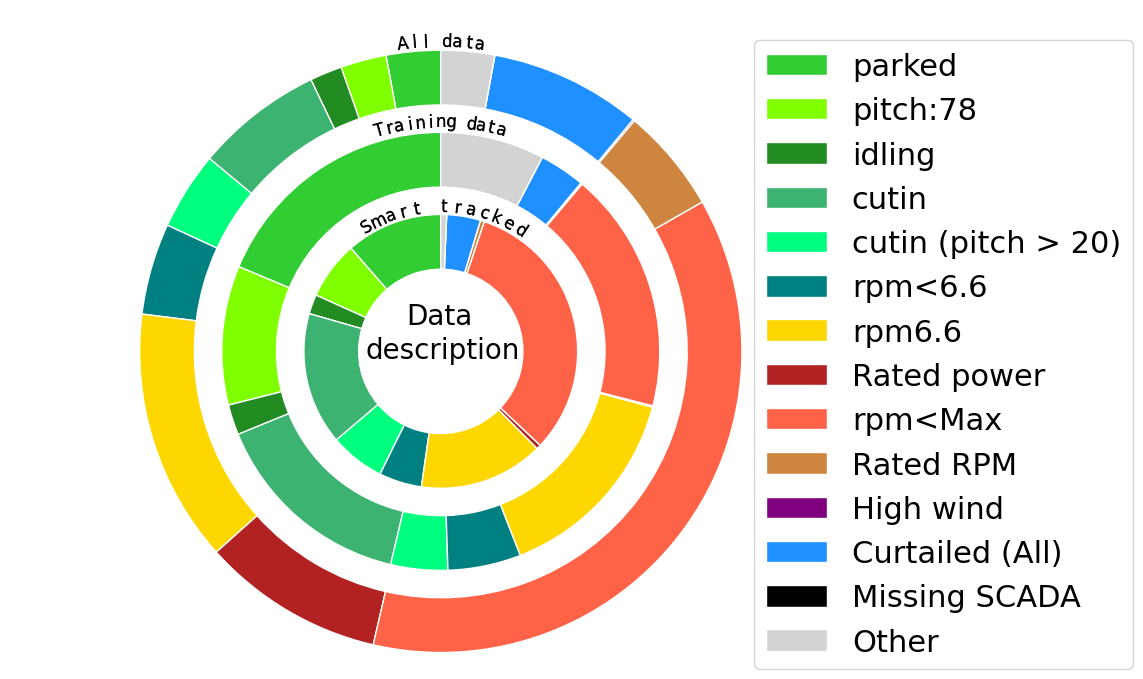

In [ ]:
plot_case_donuts(dwf_, dwf_training, dwf_smart_tracked, radiuses = [2.2, 1.6, 1.0],  show_percent=False, N=[1000, 1000, 1000], start_pos=[0.3, 0.41, 0.32])

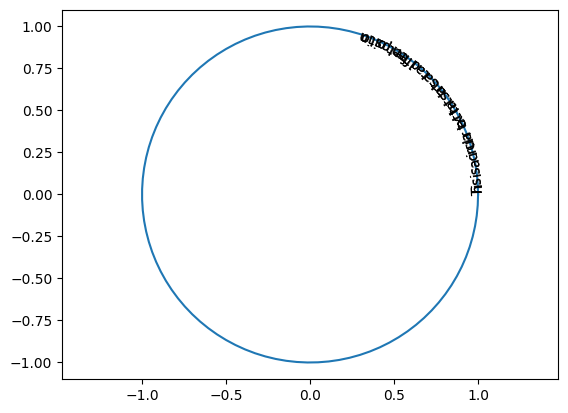

In [ ]:
from matplotlib.text import Text as mtext

class CurvedText(mtext):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, start_pos=0, fontsize=12, **kwargs):
        # Extend the superclass with an empty string
        super().__init__(x=x[0], y=y[0], text='', fontsize=fontsize, **kwargs)
        self.x = x
        self.y = y
        self.axes = axes
        self.axes.add_artist(self)
        self.text = text
        self.start_pos = start_pos  # Fractional start position along the curve
        self.fontsize = fontsize

        # Create text objects for each character
        self.text_objects = [self._make_text(t, **kwargs) for t in text]

    def _make_text(self, char, **kwargs):
        text = mtext(x=0, y=0, text=char, **kwargs)
        text.set_fontsize(self.fontsize)
        self.axes.add_artist(text)
        return text

    def draw(self, renderer):
        # Override the draw method to reposition the text objects
        scale = renderer.points_to_pixels(self.fontsize)

        # Calculate the arc length of the curve
        distances = np.hypot(np.diff(self.x), np.diff(self.y))
        arc = np.insert(np.cumsum(distances), 0, 0)

        # Calculate the fraction of the total arc length at which to place each character
        total_arc_length = arc[-1]
        char_arc_lengths = np.linspace(0, total_arc_length, len(self.text) + 1)[1:] * self.start_pos

        for char_arc, text_object in zip(char_arc_lengths, self.text_objects):
            # Find the index into the arc array closest to the target arc length for this character
            index = np.searchsorted(arc, char_arc) - 1
            arc_before = arc[index]
            arc_after = arc[min(index + 1, len(arc) - 1)]  # Prevent going out of bounds
            # Interpolate to find the exact position
            t = (char_arc - arc_before) / (arc_after - arc_before)

            # Position the character
            x = self.x[index] + (self.x[min(index + 1, len(self.x) - 1)] - self.x[index]) * t
            y = self.y[index] + (self.y[min(index + 1, len(self.y) - 1)] - self.y[index]) * t
            angle = math.degrees(math.atan2(self.y[min(index + 1, len(self.y) - 1)] - self.y[index],
                                            self.x[min(index + 1, len(self.x) - 1)] - self.x[index]))

            # Set the position and rotation
            text_object.set_x(x)
            text_object.set_y(y)
            text_object.set_rotation(angle)
            text_object.set_va('center')
            text_object.set_ha('center')

            # Draw the character
            text_object.draw(renderer)

        # Call superclass draw method
        super().draw(renderer)

# Example usage
fig, ax = plt.subplots()
N = 100
curve = [
    np.cos(np.linspace(0, 2*np.pi, N)),
    np.sin(np.linspace(0, 2*np.pi, N)),
]

# Plot the curve
ax.plot(*curve)

# Create the CurvedText object
text = CurvedText(
    x=curve[0],
    y=curve[1],
    text="This is a circular text that starts at a different position",
    axes=ax,  # Adds the text to the axes
    start_pos=0.2,  # Starting position (20% along the curve)
    fontsize=10  # Font size
)

plt.axis('equal')
plt.show()

